In [1]:
import os

os.chdir("../")
print(os.getcwd())

/rds/general/user/pg221/home/PhD_projects2/dreamer_flows/dreamer


# Read Drag values while training

In [2]:
# def load(filename=None, keys=None):
# #     filename = path.Path(filename)
#     print(f'Loading checkpoint: {filename}')
#     file = open(filename, 'rb')
#     load_data = pickle.load(file)
# #     keys = tuple(data.keys() if keys is None else keys)
#     return load_data
# #     for key in keys:
# #       if key.startswith('_'):
# #         continue
# #       try:
# #         values[key].load(data[key])
# #       except Exception:
# #         print(f'Error loading {key} from checkpoint.')
# #         raise
# #     if self._log:
# #       age = time.time() - data['_timestamp']
# #       print(f'Loaded checkpoint from {age:.0f} seconds ago.')

# data = load(filename = "logdir/Cyl/First_Test/events.out.tfevents.1717606486.cx3-1-0.cx3.hpc.ic.ac.uk.2498444.0.v2")
# print(data.keys())

In [3]:
import yaml
import numpy as np
import warnings
import dreamerv3
from dreamerv3 import embodied
warnings.filterwarnings('ignore', '.*truncated to dtype int32.*')

print("Reading config", flush =True)

# See configs.yaml for all options.
import warnings
import dreamerv3
from dreamerv3 import embodied
warnings.filterwarnings('ignore', '.*truncated to dtype int32.*')

print("Reading config", flush =True)

# Load YAML file
with open('logdir/Cyl_Horizon_Length/Cyl_large_env10_rs1_ihorizon10/config.yaml', 'r') as file:
    loaded_config = yaml.safe_load(file)

# See configs.yaml for all options.
config = embodied.Config(dreamerv3.configs['defaults'])
config = config.update(dreamerv3.configs['small'])
config = config.update(loaded_config)

2024-06-28 18:34:18.782110: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-28 18:34:19.619416: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Reading config
Reading config


In [4]:
print(config.cyl.random_start)

True


In [5]:

logdir_name = config.logdir_basepath+'/'+\
       config.logdir_dirname+'/'+\
       config.logdir_expname
config = config.update({'logdir': logdir_name, 'jax.platform': 'cpu' })
logdir = embodied.Path(config.logdir)
# logdir.mkdirs()
config.save(config.logdir+"/config.yaml")
print('Logdir', logdir)
print("Number of Envs: ", config.envs.amount)

step = embodied.Counter()
logger = embodied.Logger(step, [
  embodied.logger.TerminalOutput(),
  embodied.logger.JSONLOutput(logdir, 'metrics.jsonl'),
  embodied.logger.TensorBoardOutput(logdir),
  # embodied.logger.MLFlowOutput(logdir.name),
])

############################ Creating Env ##############################


# #make replay
# replay = embodied.replay.Uniform(
#             config.batch_length, config.replay_size, logdir / 'replay')
# eval_replay = make_replay(config, logdir / 'eval_replay', is_eval=True)
# eval_replay = embodied.replay.Uniform(
#               config.batch_length, config.replay_size, logdir / 'eval_replay')
#make env
# env = make_ks_env(config)
from make_flow_envs import make_flow_envs, make_cyl_env
from Cylinder_Env.simulation_base.env import resume_env
from embodied import wrappers
from embodied.envs import from_gym

# env = make_flow_envs(config, env_name="CYL", num_envs = config.envs.amount)
eval_env = resume_env(plot=False,
                      single_run=False,
                      horizon= 200,
                      dump_vtu= 500,
                      dump_debug = 10, 
                      random_start= True,
                      n_env=1,
                      simulation_duration=100,
                      sim_log_name = config.logdir_dirname+"/"+ \
                                         config.logdir_expname+"/test"
                      )
eval_env = from_gym.FromGym(eval_env, obs_key='vector')  # Or obs_key='vector'.
eval_env = dreamerv3.wrap_env(eval_env, config)
    
eval_env = embodied.BatchEnv([eval_env], parallel=False)

agent = dreamerv3.Agent(eval_env.obs_space, eval_env.act_space, step, config)
args  = embodied.Config(
  **config.run, logdir=config.logdir,
  batch_steps=config.batch_size * config.batch_length)

Logdir /rds/general/user/pg221/home/PhD_projects2/dreamer_flows/dreamer/logdir/Cyl_Horizon_Length/Cyl_large_env10_rs1_ihorizon10
Number of Envs:  30


--------------------------------------------------------------------------
No OpenFabrics connection schemes reported that they were able to be
used on a specific port.  As such, the openib BTL (OpenFabrics
support) will be disabled for this port.

  Local host:           cx3-15-29
  Local device:         mlx5_0
  Local port:           1
  CPCs attempted:       rdmacm, udcm
--------------------------------------------------------------------------
bash: which: line 1: syntax error: unexpected end of file
bash: error importing function definition for `which'
bash: module: line 1: syntax error: unexpected end of file
bash: error importing function definition for `module'
bash: scl: line 1: syntax error: unexpected end of file
bash: error importing function definition for `scl'
bash: ml: line 1: syntax error: unexpected end of file
bash: error importing function definition for `ml'
bash: which: line 1: syntax error: unexpected end of file
bash: error importing function definition for `whi

iUFL can be obtained from https://github.com/MiroK/ufl-interpreter
Initialising env number:  1
Number of probes: 64
Simulated 729 iterations before starting the control
--- done buffers initialisation ---
Encoder CNN shapes: {}
Encoder MLP shapes: {'vector': (66,)}
Decoder CNN shapes: {}
Decoder MLP shapes: {'vector': (66,)}
JAX devices (1): [CpuDevice(id=0)]
Policy devices: TFRT_CPU_0
Train devices:  TFRT_CPU_0


2024-06-28 18:35:07.804309: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Tracing train function.
Optimizer model_opt has 37,469,598 variables.
Optimizer actor_opt has 4,061,368 variables.
Optimizer critic_opt has 4,251,877 variables.


Loading Checkpoint Model

In [6]:
checkpoint = embodied.Checkpoint()
checkpoint.agent = agent
checkpoint.load(config.logdir+'/checkpoint.ckpt', keys=['agent'])

Loading checkpoint: /rds/general/user/pg221/home/PhD_projects2/dreamer_flows/dreamer/logdir/Cyl_Horizon_Length/Cyl_large_env10_rs1_ihorizon10/checkpoint.ckpt
Loaded checkpoint from 12627 seconds ago.


Evaluating model with the environment

In [7]:
policy = lambda *args: agent.policy(*args, mode='eval')

## Model Eval

In [ ]:
from embodied.core.basics import convert
import collections

#initializing actions
_acts = {k: convert(np.zeros((len(eval_env),) + v.shape, v.dtype))
        for k, v in eval_env.act_space.items()}
_acts['reset'] = np.ones(len(eval_env), bool)
_eps = [collections.defaultdict(list) for _ in range(len(eval_env))]
_state = None

obs  = eval_env.step(_acts)

In [ ]:
imag_hori = 10

# agent.agent.train(obs, None)
agent.agent.wm.imagine(policy, )

## Policy Eval

In [8]:
from embodied.core.basics import convert
import collections

#initializing actions
_acts = {k: convert(np.zeros((len(eval_env),) + v.shape, v.dtype))
        for k, v in eval_env.act_space.items()}
_acts['reset'] = np.ones(len(eval_env), bool)
_eps = [collections.defaultdict(list) for _ in range(len(eval_env))]
_state = None

In [9]:
from tqdm import tqdm
obs_total = [] 
acts_total = []
qs_total = []
drag = []
lift = []
control_time = 120 #in env steps
actual_eval_env = eval_env.get_actual_env()

# acts['reset'] = [True]
# obs = env.reset()
for i in tqdm(range(control_time)):
    #take a step
    assert all(len(x) == len(eval_env) for x in _acts.values())
    acts = {k: v for k, v in _acts.items() if not k.startswith('log_')}
    obs  = eval_env.step(acts)

    #read observation
    obs = {k: convert(v) for k, v in obs.items()}
    assert all(len(x) == len(eval_env) for x in obs.values()), obs
    acts, _state = policy(obs, _state)
    print(acts)
    acts = {k: convert(v) for k, v in acts.items()}
    
    acts['reset'] = obs['is_last'].copy()
    _acts = acts
    acts_total.append(acts)
    qs_total.append(actual_eval_env[0].Qs)
#     print(f"{i}: obs: ", obs)
    obs_total.append(obs)
#     if config.run.log_specificenv_data !='':
#     actual_eval_env = eval_env.get_actual_env()
#     se_keys = config.run.log_specificenv_data.split(",")

#     for key in se_keys:
#       key = key.strip()
#       avg_key_val = np.mean(np.array([getattr(actual_eval_env[i], key) \
#                                       for i in range(len(actual_eval_env))]))
#       print(np.array([getattr(actual_eval_env[i], key) for i in range(len(actual_eval_env))]))
    drag.append(actual_eval_env[0].get_Cd())
#     lift.append(getattr(actual_eval_env[0], 'avg_lift'))

  0%|          | 0/120 [00:00<?, ?it/s]

Number of probes: 64
Simulated 1497 iterations before starting the control
Tracing policy function.
Tracing policy function.


  1%|          | 1/120 [01:31<3:02:16, 91.91s/it]

{'action': array([[-0.17710449, -0.11565744]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.01771045 -0.01156574]


  2%|▏         | 2/120 [01:36<1:19:30, 40.43s/it]

{'action': array([[-0.22414038, -0.28618062]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.02241404 -0.02861806]


  2%|▎         | 3/120 [01:40<46:41, 23.95s/it]  

{'action': array([[-0.6637181 , -0.71355784]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.06637181 -0.07135578]


  3%|▎         | 4/120 [01:44<31:19, 16.20s/it]

{'action': array([[-0.5073941, -1.0308554]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.05073941 -0.1       ]


  4%|▍         | 5/120 [01:49<22:51, 11.93s/it]

{'action': array([[-0.626138 , -0.6915681]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.0626138  -0.06915681]


  5%|▌         | 6/120 [01:53<17:45,  9.35s/it]

{'action': array([[0.5557395, 0.3472616]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.05557395 0.03472617]


  6%|▌         | 7/120 [01:57<14:30,  7.71s/it]

{'action': array([[ 0.8124691 , -0.08140942]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [ 0.08124691 -0.00814094]


  7%|▋         | 8/120 [02:02<12:23,  6.64s/it]

{'action': array([[1.0409875, 1.1186154]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.1 0.1]


  8%|▊         | 9/120 [02:06<10:56,  5.92s/it]

{'action': array([[0.9665234, 0.3659167]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.09665234 0.03659168]


  8%|▊         | 10/120 [02:11<10:00,  5.46s/it]

{'action': array([[0.7509326, 0.4899942]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.07509326 0.04899942]


  9%|▉         | 11/120 [02:15<09:17,  5.11s/it]

{'action': array([[0.96315575, 0.46595237]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.09631558 0.04659524]


 10%|█         | 12/120 [02:19<08:46,  4.88s/it]

{'action': array([[ 0.9915872 , -0.08891834]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [ 0.09915872 -0.00889183]


 11%|█         | 13/120 [02:24<08:24,  4.72s/it]

{'action': array([[1.1477194, 0.6090213]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.1        0.06090213]


 12%|█▏        | 14/120 [02:28<08:08,  4.61s/it]

{'action': array([[ 1.0979122 , -0.23144697]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [ 0.1       -0.0231447]


 12%|█▎        | 15/120 [02:32<07:55,  4.53s/it]

{'action': array([[0.83745986, 0.85330325]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.08374598 0.08533032]


 13%|█▎        | 16/120 [02:37<07:44,  4.47s/it]

{'action': array([[ 0.8804905, -1.025197 ]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [ 0.08804905 -0.1       ]


 14%|█▍        | 17/120 [02:41<07:36,  4.43s/it]

{'action': array([[0.8390346, 1.1202134]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.08390345 0.1       ]


 15%|█▌        | 18/120 [02:45<07:31,  4.43s/it]

{'action': array([[1.0430894 , 0.69118106]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.1       0.0691181]


 16%|█▌        | 19/120 [02:50<07:24,  4.40s/it]

{'action': array([[0.99551255, 0.93496346]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.09955125 0.09349634]


 17%|█▋        | 20/120 [02:54<07:18,  4.38s/it]

{'action': array([[0.7322234 , 0.43373835]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.07322234 0.04337383]


 18%|█▊        | 21/120 [02:58<07:12,  4.37s/it]

{'action': array([[-0.70238113, -0.9419661 ]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.07023811 -0.09419661]


 18%|█▊        | 22/120 [03:03<07:07,  4.36s/it]

{'action': array([[-0.8896416 , -0.86917216]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.08896416 -0.08691721]


 19%|█▉        | 23/120 [03:07<07:02,  4.35s/it]

{'action': array([[-0.78158605, -0.6185926 ]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.07815861 -0.06185926]


 20%|██        | 24/120 [03:11<06:57,  4.35s/it]

{'action': array([[-0.717205  ,  0.32327157]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.0717205   0.03232715]


 21%|██        | 25/120 [03:16<06:53,  4.35s/it]

{'action': array([[0.543465  , 0.84813875]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.0543465  0.08481389]


 22%|██▏       | 26/120 [03:20<06:50,  4.37s/it]

{'action': array([[-0.31292024, -0.01944942]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.03129202 -0.00194494]


 22%|██▎       | 27/120 [03:25<06:45,  4.36s/it]

{'action': array([[0.7593337, 0.9460214]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.07593337 0.09460213]


 23%|██▎       | 28/120 [03:29<06:40,  4.35s/it]

{'action': array([[0.7903634, 1.0689912]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.07903633 0.1       ]


 24%|██▍       | 29/120 [03:33<06:35,  4.34s/it]

{'action': array([[0.90395206, 0.9406735 ]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.09039521 0.09406735]


 25%|██▌       | 30/120 [03:38<06:30,  4.34s/it]

{'action': array([[0.9034807 , 0.95750076]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.09034808 0.09575007]


 26%|██▌       | 31/120 [03:42<06:25,  4.33s/it]

{'action': array([[0.7319341, 0.8871685]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.07319341 0.08871686]


 27%|██▋       | 32/120 [03:46<06:21,  4.33s/it]

{'action': array([[0.9870387, 0.8388902]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.09870386 0.08388902]


 28%|██▊       | 33/120 [03:50<06:16,  4.33s/it]

{'action': array([[0.8877078 , 0.91346014]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.08877078 0.09134602]


 28%|██▊       | 34/120 [03:55<06:14,  4.35s/it]

{'action': array([[1.0985166 , 0.98555124]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.1        0.09855513]


 29%|██▉       | 35/120 [03:59<06:09,  4.34s/it]

{'action': array([[0.9628185, 1.1714913]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.09628185 0.1       ]


 30%|███       | 36/120 [04:04<06:04,  4.34s/it]

{'action': array([[0.97736716, 0.36540446]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.09773672 0.03654045]


 31%|███       | 37/120 [04:08<05:59,  4.33s/it]

{'action': array([[0.75337803, 0.6227055 ]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.0753378  0.06227055]


 32%|███▏      | 38/120 [04:12<05:55,  4.33s/it]

{'action': array([[0.94722366, 0.9488948 ]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.09472237 0.09488948]


 32%|███▎      | 39/120 [04:17<05:50,  4.32s/it]

{'action': array([[0.87033373, 0.5555461 ]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.08703337 0.05555461]


 33%|███▎      | 40/120 [04:21<05:45,  4.32s/it]

{'action': array([[ 0.9287564, -0.4470046]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [ 0.09287565 -0.04470045]


 34%|███▍      | 41/120 [04:25<05:41,  4.33s/it]

{'action': array([[0.8889793, 0.738773 ]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.08889794 0.0738773 ]


 35%|███▌      | 42/120 [04:30<05:39,  4.35s/it]

{'action': array([[1.0908064, 0.9808143]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.1        0.09808142]


 36%|███▌      | 43/120 [04:34<05:33,  4.34s/it]

{'action': array([[0.9072661, 0.3025311]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.09072661 0.03025311]


 37%|███▋      | 44/120 [04:38<05:29,  4.33s/it]

{'action': array([[ 0.3877648, -0.1788567]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [ 0.03877648 -0.01788567]


 38%|███▊      | 45/120 [04:43<05:25,  4.33s/it]

{'action': array([[0.4975166, 0.7975707]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.04975167 0.07975707]


 38%|███▊      | 46/120 [04:47<05:20,  4.33s/it]

{'action': array([[ 0.60548514, -0.04187524]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [ 0.06054852 -0.00418752]


 39%|███▉      | 47/120 [04:51<05:16,  4.33s/it]

{'action': array([[-0.2601721 , -0.21478659]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.02601721 -0.02147866]


 40%|████      | 48/120 [04:56<05:11,  4.33s/it]

{'action': array([[-0.00662796,  0.05269336]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.0006628   0.00526934]


 41%|████      | 49/120 [05:00<05:07,  4.33s/it]

{'action': array([[-0.9518006, -0.9513265]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.09518006 -0.09513265]


 42%|████▏     | 50/120 [05:04<05:04,  4.36s/it]

{'action': array([[-1.0617497, -0.940738 ]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.1       -0.0940738]


 42%|████▎     | 51/120 [05:09<04:59,  4.34s/it]

{'action': array([[-1.0093511, -0.6542705]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.1        -0.06542706]


 43%|████▎     | 52/120 [05:13<04:55,  4.34s/it]

{'action': array([[-0.7896669, -0.4263056]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.07896669 -0.04263056]


 44%|████▍     | 53/120 [05:17<04:50,  4.34s/it]

{'action': array([[-0.6133637 , -0.16056569]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.06133637 -0.01605657]


 45%|████▌     | 54/120 [05:22<04:46,  4.34s/it]

{'action': array([[-0.15612267,  0.05733598]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.01561227  0.0057336 ]


 46%|████▌     | 55/120 [05:26<04:41,  4.33s/it]

{'action': array([[-0.47931856, -0.19552852]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.04793186 -0.01955285]


 47%|████▋     | 56/120 [05:30<04:37,  4.33s/it]

{'action': array([[0.3784576 , 0.68031764]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.03784576 0.06803177]


 48%|████▊     | 57/120 [05:35<04:32,  4.33s/it]

{'action': array([[0.01381268, 0.52276963]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.00138127 0.05227697]


 48%|████▊     | 58/120 [05:39<04:33,  4.41s/it]

{'action': array([[0.09163224, 0.43411338]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.00916323 0.04341134]


 49%|████▉     | 59/120 [05:43<04:27,  4.38s/it]

{'action': array([[-0.3936631, -0.3636557]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.03936631 -0.03636557]


 50%|█████     | 60/120 [05:48<04:21,  4.36s/it]

{'action': array([[-0.74148583, -0.6418323 ]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.07414859 -0.06418323]


 51%|█████     | 61/120 [05:52<04:16,  4.35s/it]

{'action': array([[0.18799984, 0.8995738 ]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.01879998 0.08995738]


 52%|█████▏    | 62/120 [05:56<04:12,  4.35s/it]

{'action': array([[-0.2718963 , -0.60586065]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.02718963 -0.06058607]


 52%|█████▎    | 63/120 [06:01<04:07,  4.34s/it]

{'action': array([[-0.91085356, -0.98281854]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.09108536 -0.09828185]


 53%|█████▎    | 64/120 [06:05<04:02,  4.34s/it]

{'action': array([[1.1054968, 0.9026143]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.1        0.09026144]


 54%|█████▍    | 65/120 [06:09<03:58,  4.33s/it]

{'action': array([[0.47871894, 0.22759593]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.0478719  0.02275959]


 55%|█████▌    | 66/120 [06:14<03:55,  4.35s/it]

{'action': array([[0.76198524, 0.33090246]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.07619853 0.03309024]


 56%|█████▌    | 67/120 [06:18<03:50,  4.35s/it]

{'action': array([[0.725302  , 0.86243355]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.0725302  0.08624335]


 57%|█████▋    | 68/120 [06:22<03:45,  4.34s/it]

{'action': array([[0.7033515 , 0.76729506]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.07033515 0.07672951]


 57%|█████▊    | 69/120 [06:27<03:40,  4.33s/it]

{'action': array([[-0.20726717, -0.6758952 ]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.02072672 -0.06758952]


 58%|█████▊    | 70/120 [06:31<03:36,  4.33s/it]

{'action': array([[-0.2711349, -0.7129047]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.02711349 -0.07129047]


 59%|█████▉    | 71/120 [06:35<03:32,  4.33s/it]

{'action': array([[0.9344371, 0.8230632]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.09344371 0.08230632]


 60%|██████    | 72/120 [06:40<03:27,  4.33s/it]

{'action': array([[0.7980911 , 0.31243145]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.07980912 0.03124315]


 61%|██████    | 73/120 [06:44<03:23,  4.32s/it]

{'action': array([[0.3914247 , 0.07107953]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.03914247 0.00710795]


 62%|██████▏   | 74/120 [06:48<03:20,  4.35s/it]

{'action': array([[0.68567365, 0.58750284]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.06856737 0.05875028]


 62%|██████▎   | 75/120 [06:53<03:15,  4.34s/it]

{'action': array([[0.4448651 , 0.31424916]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.04448651 0.03142492]


 63%|██████▎   | 76/120 [06:57<03:10,  4.33s/it]

{'action': array([[-0.5035436 , -0.70695424]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.05035436 -0.07069542]


 64%|██████▍   | 77/120 [07:01<03:06,  4.33s/it]

{'action': array([[-0.8666547, -0.7288855]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.08666547 -0.07288855]


 65%|██████▌   | 78/120 [07:06<03:01,  4.33s/it]

{'action': array([[-0.752354 , -0.7716712]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.0752354  -0.07716712]


 66%|██████▌   | 79/120 [07:10<02:57,  4.33s/it]

{'action': array([[-0.88908565, -0.85806113]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.08890857 -0.08580612]


 67%|██████▋   | 80/120 [07:14<02:53,  4.33s/it]

{'action': array([[-0.6540024 , -0.42285848]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.06540024 -0.04228585]


 68%|██████▊   | 81/120 [07:19<02:48,  4.32s/it]

{'action': array([[-0.36765894, -0.01319552]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.0367659  -0.00131955]


 68%|██████▊   | 82/120 [07:23<02:45,  4.35s/it]

{'action': array([[-0.3172338, -0.3336345]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.03172338 -0.03336345]


 69%|██████▉   | 83/120 [07:27<02:40,  4.34s/it]

{'action': array([[-0.6624651 , -0.40081945]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.06624651 -0.04008194]


 70%|███████   | 84/120 [07:32<02:35,  4.33s/it]

{'action': array([[-0.11832653,  0.46841484]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.01183265  0.04684148]


 71%|███████   | 85/120 [07:36<02:31,  4.33s/it]

{'action': array([[-0.41377905, -0.10063474]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.0413779  -0.01006348]


 72%|███████▏  | 86/120 [07:40<02:27,  4.33s/it]

{'action': array([[-0.9652891, -0.6898599]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.09652891 -0.06898599]


 72%|███████▎  | 87/120 [07:45<02:22,  4.33s/it]

{'action': array([[-0.6989113 , -0.08530663]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.06989113 -0.00853066]


 73%|███████▎  | 88/120 [07:49<02:18,  4.33s/it]

{'action': array([[-0.18066473, -0.00525576]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.01806647 -0.00052558]


 74%|███████▍  | 89/120 [07:53<02:14,  4.32s/it]

{'action': array([[-0.8414549 , -0.67642814]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.08414549 -0.06764282]


 75%|███████▌  | 90/120 [07:58<02:10,  4.34s/it]

{'action': array([[0.12593265, 0.58012676]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.01259327 0.05801268]


 76%|███████▌  | 91/120 [08:02<02:05,  4.34s/it]

{'action': array([[-0.07395807, -0.21875887]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.0073958  -0.02187589]


 77%|███████▋  | 92/120 [08:06<02:01,  4.33s/it]

{'action': array([[-0.6985925 , -0.76363224]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.06985925 -0.07636323]


 78%|███████▊  | 93/120 [08:11<01:56,  4.33s/it]

{'action': array([[0.56647044, 0.9831831 ]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.05664704 0.09831832]


 78%|███████▊  | 94/120 [08:15<01:52,  4.33s/it]

{'action': array([[ 0.09926057, -0.46523547]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [ 0.00992606 -0.04652355]


 79%|███████▉  | 95/120 [08:19<01:48,  4.33s/it]

{'action': array([[-0.7604175 , -0.67854667]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.07604175 -0.06785467]


 80%|████████  | 96/120 [08:24<01:43,  4.33s/it]

{'action': array([[0.89593756, 1.1152855 ]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.08959376 0.1       ]


 81%|████████  | 97/120 [08:28<01:39,  4.33s/it]

{'action': array([[-0.06441637, -0.3801867 ]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.00644164 -0.03801867]


 82%|████████▏ | 98/120 [08:32<01:35,  4.35s/it]

{'action': array([[-0.29770443, -0.35859308]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.02977045 -0.03585931]


 82%|████████▎ | 99/120 [08:37<01:31,  4.34s/it]

{'action': array([[ 0.13844398, -0.06606208]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [ 0.0138444  -0.00660621]


 83%|████████▎ | 100/120 [08:41<01:26,  4.33s/it]

{'action': array([[-0.12622109, -0.25915545]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.01262211 -0.02591555]


 84%|████████▍ | 101/120 [08:45<01:22,  4.33s/it]

{'action': array([[0.10908989, 0.39312732]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.01090899 0.03931273]


 85%|████████▌ | 102/120 [08:50<01:17,  4.33s/it]

{'action': array([[-0.193783  , -0.33830553]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.0193783  -0.03383055]


 86%|████████▌ | 103/120 [08:54<01:13,  4.32s/it]

{'action': array([[-1.0608263, -0.9303421]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.1        -0.09303421]


 87%|████████▋ | 104/120 [08:58<01:09,  4.32s/it]

{'action': array([[-0.03237911,  0.28466198]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.00323791  0.0284662 ]


 88%|████████▊ | 105/120 [09:03<01:04,  4.32s/it]

{'action': array([[-0.29231685, -0.49227455]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.02923169 -0.04922745]


 88%|████████▊ | 106/120 [09:07<01:00,  4.35s/it]

{'action': array([[-0.7123194, -0.5846196]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.07123194 -0.05846196]


 89%|████████▉ | 107/120 [09:11<00:56,  4.34s/it]

{'action': array([[-0.22007132, -0.14036953]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.02200713 -0.01403695]


 90%|█████████ | 108/120 [09:16<00:51,  4.33s/it]

{'action': array([[-0.6510128 , -0.44561663]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.06510128 -0.04456166]


 91%|█████████ | 109/120 [09:20<00:47,  4.33s/it]

{'action': array([[-0.601775  , -0.13026251]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.0601775  -0.01302625]


 92%|█████████▏| 110/120 [09:24<00:43,  4.33s/it]

{'action': array([[-0.88159466, -0.4029591 ]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.08815946 -0.04029591]


 92%|█████████▎| 111/120 [09:29<00:38,  4.33s/it]

{'action': array([[-0.73025185, -1.0145091 ]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.07302519 -0.1       ]


 93%|█████████▎| 112/120 [09:33<00:34,  4.33s/it]

{'action': array([[-0.9565008 , -0.30248618]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.09565008 -0.03024862]


 94%|█████████▍| 113/120 [09:37<00:30,  4.33s/it]

{'action': array([[0.31515104, 0.6955225 ]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.0315151  0.06955226]


 95%|█████████▌| 114/120 [09:42<00:26,  4.36s/it]

{'action': array([[-0.4742841 , -0.28378984]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.04742841 -0.02837899]


 96%|█████████▌| 115/120 [09:46<00:21,  4.34s/it]

{'action': array([[0.29797253, 0.8126475 ]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.02979726 0.08126476]


 97%|█████████▋| 116/120 [09:50<00:17,  4.34s/it]

{'action': array([[0.04397085, 0.5558608 ]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [0.00439708 0.05558608]


 98%|█████████▊| 117/120 [09:55<00:13,  4.33s/it]

{'action': array([[-0.6215565 , -0.23043253]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.06215565 -0.02304325]


 98%|█████████▊| 118/120 [09:59<00:08,  4.33s/it]

{'action': array([[-0.6666968 , -0.22875969]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.06666968 -0.02287597]


 99%|█████████▉| 119/120 [10:03<00:04,  4.33s/it]

{'action': array([[-0.34481484, -0.5554206 ]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}
action:  [-0.03448148 -0.05554206]


100%|██████████| 120/120 [10:08<00:00,  5.07s/it]

{'action': array([[-0.7770451 , -0.65130097]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}


Text(0.5, 0, 'action steps')

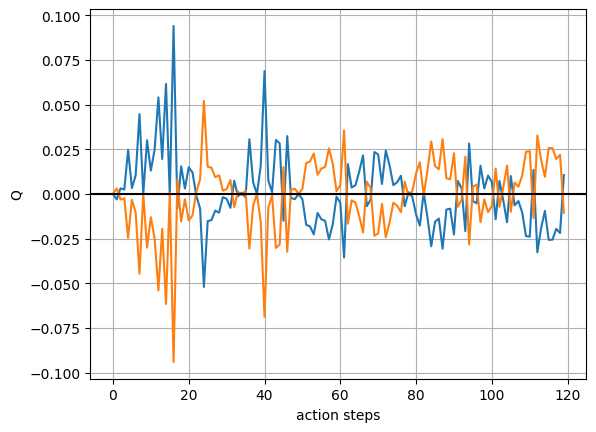

In [14]:
import matplotlib.pyplot as plt
plt.plot(qs_total)
plt.axhline(y=0, color='black', linestyle='-')
plt.grid('on')
plt.ylabel("Q")
plt.xlabel("action steps")

Text(0, 0.5, 'Cd')

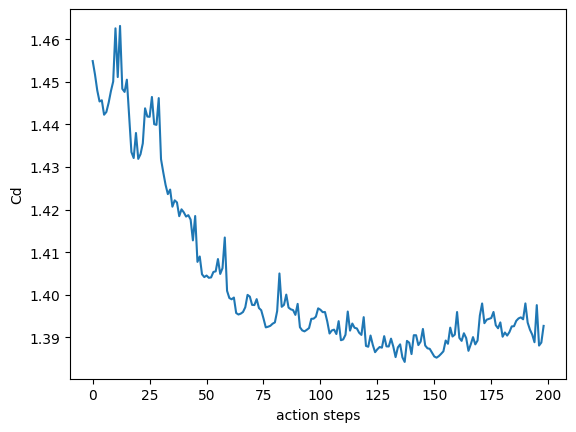

In [36]:
# log_specificenv_data = "episode_drags, avg_drag"
# actual_env = eval_env.get_actual_env()
# se_keys = log_specificenv_data.split(",")
drags = actual_eval_env[0].episode_drags[::actual_eval_env[0].number_steps_execution]
plt.plot(np.arange(drags.shape[0]), -2*drags)
plt.xlabel("action steps")
plt.ylabel("Cd")

Text(0, 0.5, 'Cl')

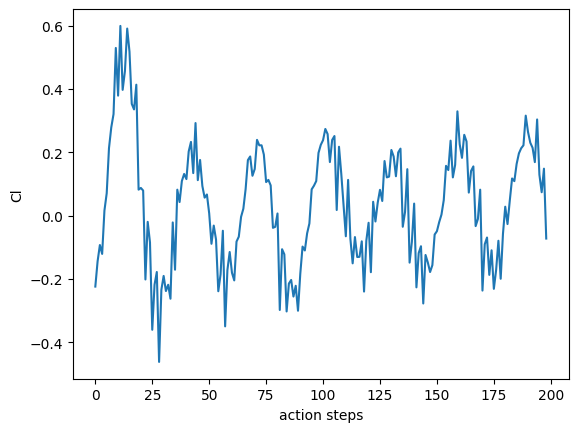

In [38]:
# log_specificenv_data = "episode_drags, avg_drag"
# actual_env = eval_env.get_actual_env()
# se_keys = log_specificenv_data.split(",")
lifts = actual_eval_env[0].episode_lifts[::actual_eval_env[0].number_steps_execution]
plt.plot(np.arange(drags.shape[0]), 2*lifts)
plt.xlabel("action steps")
plt.ylabel("Cl")

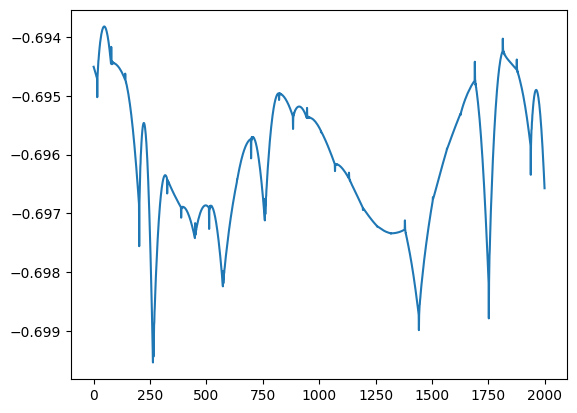

In [25]:
plt.plot(actual_eval_env[0].history_parameters["drag"].get())#[::-actual_eval_env[0].number_steps_execution])

In [15]:
#Collecting Reward and observations
import matplotlib.pyplot as plt

obs_data = obs_total[0]['vector']
obs_reward = obs_total[0]['reward']
acts_data = acts_total[0]['action']
for i in range(1,control_time):
    obs_data   = np.concatenate((obs_data  , obs_total[i]['vector']), axis = 0)
    obs_reward = np.concatenate((obs_reward, obs_total[i]['reward']), axis = 0)
    acts_data  = np.concatenate((acts_data , acts_total[i]['action']) , axis = 0)

# total_obs_data = np.concatenate((u_hist, obs_data), axis = 0)

print("obs_data shape: ", obs_data.shape)
# print("total_obs_data shape: ", total_obs_data.shape)
print("obs_reward shape: ", obs_reward.shape)
print("acts_data shape: ", acts_data.shape)

obs_data shape:  (200, 66)
obs_reward shape:  (200,)
acts_data shape:  (200, 2)


In [48]:
actual_env = eval_env.get_actual_env()
print(actual_env.)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 actual_env = eval_env.get_actual_env()                                                       │
│ ❱ 2 print(actual_env.episode_drags)                                                              │
│   3                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'list' object has no attribute 'episode_drags'

In [20]:
plt.figure()
action_step_dt = 0.25
drag = -2*np.array(actual_eval_env.episode_drags)
plt.plot(np.arange(drag.shape[0])*action_step_dt,drag)
plt.grid()
plt.xlabel("t")
plt.ylabel("Cd")

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:3                                                                                    │
│                                                                                                  │
│   1 plt.figure()                                                                                 │
│   2 action_step_dt = 0.25                                                                        │
│ ❱ 3 drag = -2*np.array(actual_eval_env.episode_drags)                                            │
│   4 plt.plot(np.arange(drag.shape[0])*action_step_dt,drag)                                       │
│   5 plt.grid()                                                                                   │
│   6 plt.xlabel("t")                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'list' object has no attribute 'episode_drags'

<Figure size 640x480 with 0 Axes>

Text(0, 0.5, 'Reward')

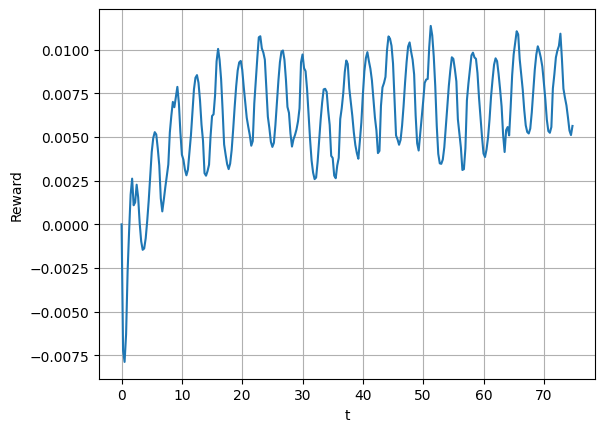

In [71]:
plt.figure()
action_step_dt = 0.25
plt.plot(np.arange(obs_reward.shape[0])*action_step_dt,obs_reward)
plt.grid()
plt.xlabel("t")
plt.ylabel("Reward")

# plt.figure()
# plt.hist(acts_data.flatten())

# plt.figure()
# from scipy.stats import norm
# mu, std = norm.fit(acts_data.flatten())

# # Generate points on the x-axis
# xmin = acts_data.flatten().min() - 3 * std
# xmax = acts_data.flatten().max() + 3 * std
# x = np.linspace(xmin, xmax, 100)

# # Generate the PDF values
# p = norm.pdf(x, mu, std)

# # Plot the PDF curve
# plt.plot(x, p, 'k', linewidth=2)

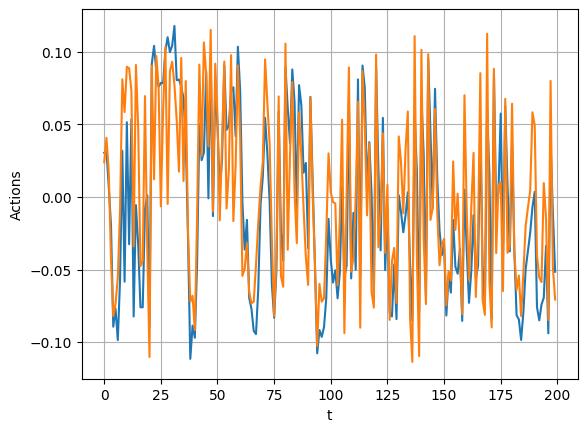

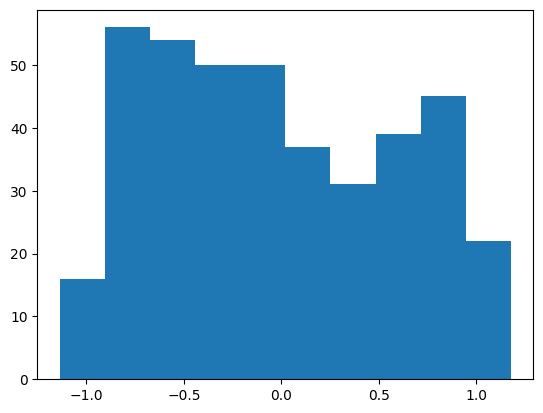

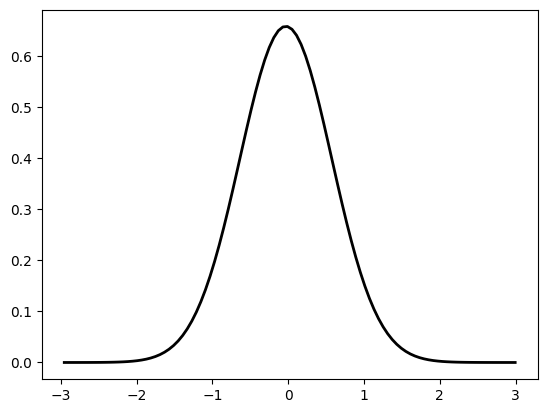

In [39]:
import matplotlib.pyplot as plt
plt.figure()
action_step_dt = 1
plt.plot(np.arange(acts_data.shape[0])*action_step_dt,acts_data*0.1)
plt.grid()
plt.xlabel("t")
plt.ylabel("Actions")

plt.figure()
plt.hist(acts_data.flatten())

plt.figure()
from scipy.stats import norm
mu, std = norm.fit(acts_data.flatten())

# Generate points on the x-axis
xmin = acts_data.flatten().min() - 3 * std
xmax = acts_data.flatten().max() + 3 * std
x = np.linspace(xmin, xmax, 100)

# Generate the PDF values
p = norm.pdf(x, mu, std)

# Plot the PDF curve
plt.plot(x, p, 'k', linewidth=2)